In [1]:
import contextily
import datetime
import geopandas
import glob
import numpy
import pandas
import shapely.ops
from matplotlib import pyplot, colors, cm, lines, patches

In [2]:
segments = geopandas.read_file("analysis/geometries/segments.geojson").to_crs({"init": "epsg:3857"})
stations = geopandas.read_file("analysis/geometries/stations.geojson").to_crs({"init": "epsg:3857"})

In [3]:
RUSH_HOUR_COLOR="#0369a3"
OFF_PEAK_COLOR="#a33e03"
NEU_COLOR="#d41b2c"

In [4]:
LINE_COLORS = {
    "Orange": "#ed8b00",
    "Red": "#da291c",
    "Green": "#00843d",
    "Blue": "#003da5"
}

# number of people who take public transit

Text(0.5, 1.0, "Commuting pattern estimates, Boston-Cambridge-Somerville Area, 2018 (O'Brien et al, 2019)")

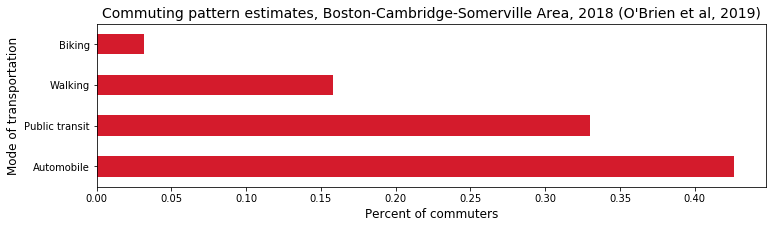

In [5]:
COLUMN_NAMES = {
    "ByAuto": "Automobile",
    "ByPubTrans": "Public transit",
    "ByBike": "Biking",
    "ByWalk": "Walking"
}
df_acs = pandas.read_csv("analysis/ACS_1418_BLKGRP.csv")
df_boston_area = df_acs[df_acs["Town"].isin({"BOSTON", "CAMBRIDGE", "SOMERVILLE"})]
pop_boston_area = df_boston_area["TotalPop"].sum()

(figure, axis) = pyplot.subplots(figsize=(12, 3))
pandas.DataFrame(
    [
        (COLUMN_NAMES[column], (df_boston_area[column] * df_boston_area["TotalPop"]).sum() / pop_boston_area)
        for column in ["ByAuto", "ByPubTrans", "ByBike", "ByWalk"]
    ],
    columns=["Mode of transportation", "Percent"]
)\
    .set_index("Mode of transportation")\
    .reindex(COLUMN_NAMES.values())\
    ["Percent"]\
    .sort_values(ascending=False)\
    .plot.barh(legend=False, color=NEU_COLOR)
axis.set_ylabel("Mode of transportation", fontsize=12)
axis.set_xlabel("Percent of commuters", fontsize=12)
axis.set_title("Commuting pattern estimates, Boston-Cambridge-Somerville Area, 2018 (O'Brien et al, 2019)", fontsize=14)

# distribution of observations

In [6]:
SORTED_HOURS = (
    ["12AM"]
    + [str(hour + 1) + "AM" for hour in range(11)]
    + ["12PM"]
    + [str(hour + 1) + "PM" for hour in range(11)]
)
HOUR_TICK_POSITIONS = [
    i
    for i in range(len(SORTED_HOURS))
    if i % 2 == 1
]

def label_hour(hour):
    if hour >= 12:
        ampm = "PM"
    else:
        ampm = "AM"
    return str(hour % 12) + ampm

print(SORTED_HOURS)
print(HOUR_TICK_POSITIONS)

['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]


Text(0.5, 1.0, 'Distribution of sampling times, 2018 pilot study')

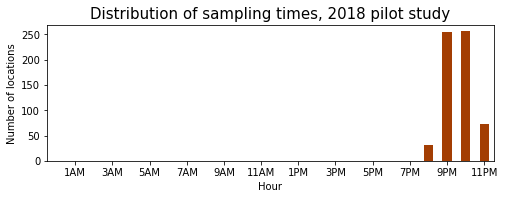

In [7]:
(figure, axis) = pyplot.subplots(figsize=(8, 2.5))
(
    pandas.concat([
        pandas.read_csv(path)
        for path in glob.glob("labels/*")
    ])["START"]/1000
)\
    .apply(datetime.datetime.fromtimestamp)\
    .dt.hour\
    .apply(label_hour)\
    .value_counts()\
    .reindex(SORTED_HOURS)\
    .plot.bar(ax=axis, rot=0, color=OFF_PEAK_COLOR)
axis.set_xlabel("Hour")
axis.set_ylabel("Number of locations")
axis.set_xticks(HOUR_TICK_POSITIONS)
axis.set_xticklabels([SORTED_HOURS[i] for i in HOUR_TICK_POSITIONS])
axis.set_title("Distribution of sampling times, 2018 pilot study", fontsize=15)

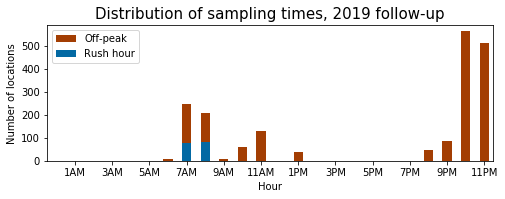

In [8]:
times_newdata = pandas.to_datetime(pandas.concat([
    pandas.read_csv(path)
    for path in glob.glob("data/*/timestamps.csv")
])["TIME"].dropna())

times_rush_hour = (
    (times_newdata.dt.hour >= 7)
    & (times_newdata.dt.hour <= 9)
    & (times_newdata.dt.day <= 5)
)

counts_rush_hour = times_newdata[times_rush_hour].dt.hour.apply(label_hour)\
    .value_counts()\
    .reindex(SORTED_HOURS)\
    .fillna(0)
counts_off_peak = times_newdata[~times_rush_hour].dt.hour.apply(label_hour)\
    .value_counts()\
    .reindex(SORTED_HOURS)\
    .fillna(0)

(figure, axis) = pyplot.subplots(figsize=(8, 2.5))
(counts_off_peak + counts_rush_hour).plot.bar(ax=axis, rot=0, color=OFF_PEAK_COLOR, label="Off-peak")
counts_rush_hour.plot.bar(ax=axis, rot=0, color=RUSH_HOUR_COLOR, label="Rush hour")
axis.set_xlabel("Hour")
axis.set_ylabel("Number of locations")
axis.set_xticks(HOUR_TICK_POSITIONS)
axis.set_xticklabels([SORTED_HOURS[i] for i in HOUR_TICK_POSITIONS])
axis.set_title("Distribution of sampling times, 2019 follow-up", fontsize=15)
axis.legend()

# coverage

2.893805309734513

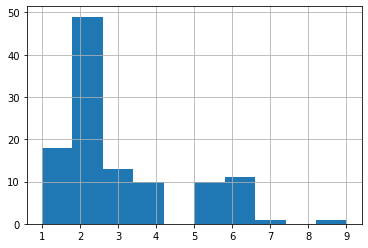

In [9]:
coverage_2018 = (
    pandas.concat([
        pandas.read_csv(path)
        for path in glob.glob("labels/*")
    ])
).query("STATUS=='stopped'").groupby("LOCATION")["POSITION"].count()
coverage_2018.hist()
coverage_2018.mean()

8.921052631578947

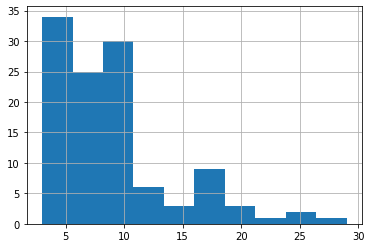

In [10]:
coverage_2019 = (
    pandas.concat([
        pandas.read_csv(path)
        for path in glob.glob("data/*/timestamps.csv")
    ])
).query("STATUS=='Arrived'").groupby(["LOCATION", "STATUS"])["ROUTE"].count()
coverage_2019.hist()
coverage_2019.mean()

# noise

In [11]:
gdf_noise = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/segments/directionless/noise.csv"),
    segments,
    on=["START_STATION", "END_STATION", "ROUTE"]
))
gdf_noise.sample(3)

,START_STATION,END_STATION,ROUTE,variable,value,LINE,length,GRADE,geometry
388,Reservoir,Beaconsfield,D,CORRECTED_VALUE.std,3.461362,Green,685.371375,1,"LINESTRING (-7920201.323 5211314.732, -7920195..."
95,Brigham Circle,Longwood Medical Area,E,CORRECTED_VALUE.median,70.700000,Green,385.349634,2,"LINESTRING (-7915230.370 5211229.068, -7915209..."
339,North Station,Community College,Orange,CORRECTED_VALUE.count,100.000000,Orange,1310.005691,"1,7","LINESTRING (-7910353.980 5215839.404, -7910426..."


[]

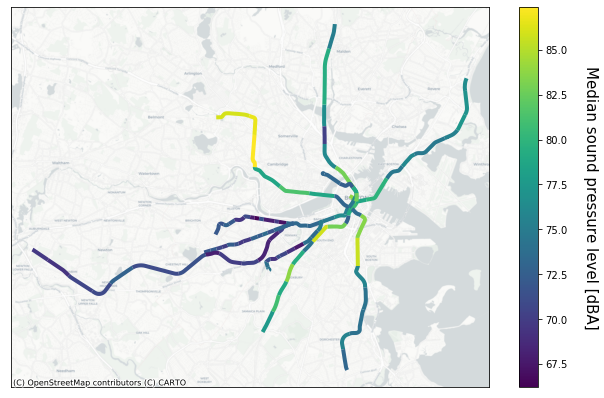

In [12]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))

temp = gdf_noise[gdf_noise["variable"] == "CORRECTED_VALUE.median"]
temp.plot(ax=axis, column="value", linewidth=4)

colormap = cm.get_cmap("viridis")
normalize = colors.Normalize(vmin=temp["value"].min(), vmax=temp["value"].max())
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap)
)
colorbar.set_label(
    "Median sound pressure level [dBA]",
    rotation=270,
    labelpad=30,
    fontsize=15
)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

#axis.set_title("Distribution of sound pressure", fontsize=15)

[]

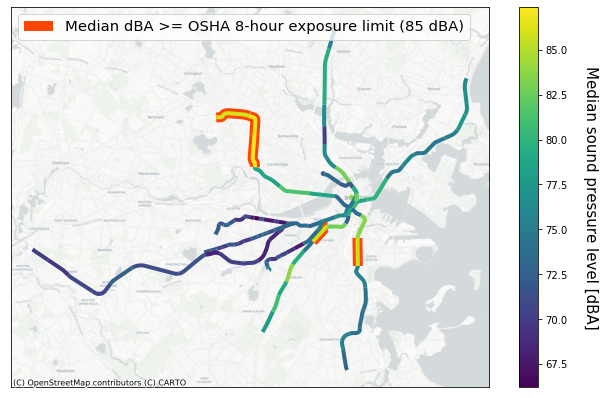

In [13]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))

temp = gdf_noise[gdf_noise["variable"] == "CORRECTED_VALUE.median"]
temp[temp["value"] >= 85].plot(ax=axis, color="orangered", linewidth=10, label="Median dBA >= OSHA 8-hour exposure limit (85 dBA)")
temp.plot(ax=axis, column="value", linewidth=4)

colormap = cm.get_cmap("viridis")
normalize = colors.Normalize(vmin=temp["value"].min(), vmax=temp["value"].max())
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap)
)
colorbar.set_label(
    "Median sound pressure level [dBA]",
    rotation=270,
    labelpad=30,
    fontsize=15
)

axis.legend(fontsize=14.75, loc="upper left")

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

#axis.set_title("Distribution of sound pressure", fontsize=15)

# particulates

In [14]:
gdf_pm_segments = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/segments/directionless/particulates.csv"),
    segments,
    on=["START_STATION", "END_STATION", "ROUTE"]
))
gdf_pm_stations = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/stations/directionless/particulates.csv"),
    stations,
    on=["STATION", "ROUTE"]
))

Text(0.5, 1, 'Geospatial distribution of particulates')

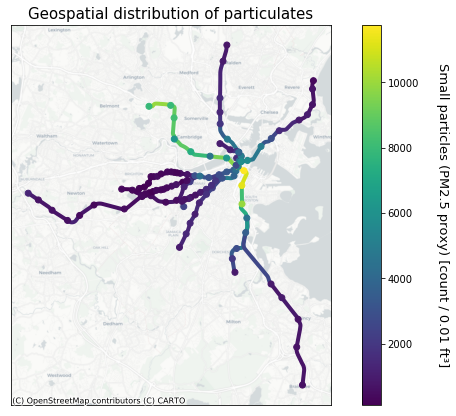

In [15]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))

temp1 = gdf_pm_segments[gdf_pm_segments["variable"] == "SMALLPARTICLES.mean"]
temp2 = gdf_pm_stations[gdf_pm_stations["variable"] == "SMALLPARTICLES.mean"]

colormap = cm.get_cmap("viridis")
normalize = colors.Normalize(
    vmin=min(temp1["value"].min(), temp2["value"].min()),
    vmax=max(temp1["value"].max(), temp2["value"].max())
)
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap),
    ax=axis
)
colorbar.set_label(
    "Small particles (PM2.5 proxy) [count / 0.01 ft³]",
    rotation=270,
    labelpad=30,
    fontsize=13
)

temp1.plot(ax=axis, column="value", linewidth=4, zorder=1, cmap=colormap)
temp2.plot(ax=axis, column="value", zorder=2, cmap=colormap)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

pyplot.title("Geospatial distribution of particulates", fontsize=15)

Text(0.5, 1, 'Number of observations')

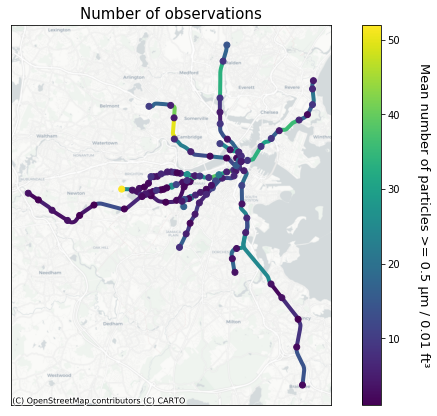

In [16]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))

temp1 = gdf_pm_segments[gdf_pm_segments["variable"] == "SMALLPARTICLES.count"]
temp2 = gdf_pm_stations[gdf_pm_stations["variable"] == "SMALLPARTICLES.count"]

colormap = cm.get_cmap("viridis")
normalize = colors.Normalize(
    vmin=min(temp1["value"].min(), temp2["value"].min()),
    vmax=max(temp1["value"].max(), temp2["value"].max())
)
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap),
    ax=axis
)
colorbar.set_label(
    "Mean number of particles >= 0.5 μm / 0.01 ft³",
    rotation=270,
    labelpad=30,
    fontsize=13
)

temp1.plot(ax=axis, column="value", linewidth=4, zorder=1, cmap=colormap)
temp2.plot(ax=axis, column="value", zorder=2, cmap=colormap)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

pyplot.title("Number of observations", fontsize=15)

In [17]:
df_particulates_off_peak = pandas.concat([
    pandas.read_csv("output/stations/directionless/particulates_off_peak.csv"),
    pandas.read_csv("output/segments/directionless/particulates_off_peak.csv")
])
df_particulates_rush_hour = pandas.concat([
    pandas.read_csv("output/stations/directionless/particulates_rush_hour.csv"),
    pandas.read_csv("output/segments/directionless/particulates_rush_hour.csv")
])

Text(0.5, 1, 'Directional variations in particle counts')

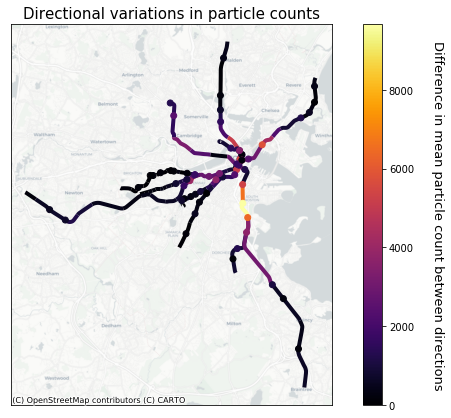

In [18]:
def difference_between_directions(df):
    dir0 = df[df["DIRECTION"] == 0]
    dir1 = df[df["DIRECTION"] == 1]
    if (len(dir0) == 0) or len(dir1) == 0:
        return None
    else:
        return abs(dir0.iloc[0]["value"] - dir1.iloc[0]["value"])

gdf_stations_diff = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/stations/by_direction/particulates_off_peak.csv")\
        .query("variable=='SMALLPARTICLES.mean'")\
        .groupby(["STATION", "ROUTE"])\
        .apply(difference_between_directions)\
        .rename("difference")\
        .reset_index(),
    stations,
    on=["STATION", "ROUTE"]
))
gdf_segments_diff = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/segments/by_direction/particulates_off_peak.csv")\
        .query("variable=='SMALLPARTICLES.mean'")\
        .groupby(["START_STATION", "END_STATION", "ROUTE"])\
        .apply(difference_between_directions)\
        .rename("difference")\
        .reset_index(),
    segments,
    on=["START_STATION", "END_STATION", "ROUTE"]
))

(figure, axis) = pyplot.subplots(figsize=(11, 7))

abs_max = max(
    gdf_stations_diff["difference"].abs().max(),
    gdf_segments_diff["difference"].abs().max()
)

colormap = cm.get_cmap("inferno")
normalize = colors.Normalize(vmin=0, vmax=abs_max)
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap),
    ax=axis
)
colorbar.set_label(
    "Difference in mean particle count between directions",
    rotation=270,
    labelpad=30,
    fontsize=13
)

#segments.plot(ax=axis, color="darkgrey", linewidth=5, zorder=1)
#stations.plot(ax=axis, color="darkgrey", markersize=40, zorder=2)

gdf_segments_diff.plot(ax=axis, column="difference", linewidth=4, zorder=3, cmap=colormap)
gdf_stations_diff.plot(ax=axis, column="difference", zorder=4, cmap=colormap)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

pyplot.title("Directional variations in particle counts", fontsize=15)

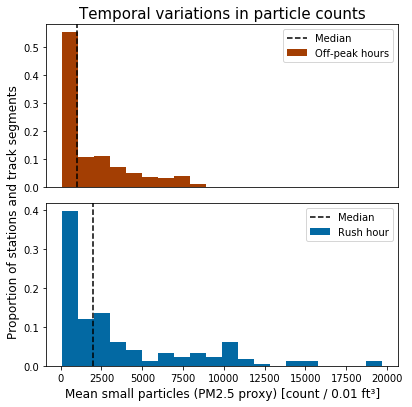

In [19]:
off_peak = df_particulates_off_peak[df_particulates_off_peak["variable"] == "SMALLPARTICLES.mean"]["value"]
rush_hour = df_particulates_rush_hour[df_particulates_rush_hour["variable"] == "SMALLPARTICLES.mean"]["value"]
hist_range=( min(off_peak.min(), rush_hour.min()), max(off_peak.max(), rush_hour.max()) )

(figure, axes) = pyplot.subplots(2, 1, figsize=(6, 6))

off_peak.hist(
    ax=axes[0], grid=False, bins=20, range=hist_range, color=OFF_PEAK_COLOR, label="Off-peak hours",
    weights=numpy.ones_like(off_peak)/len(off_peak)
)
axes[0].axvline(off_peak.median(), color="black", linestyle="--", label="Median")
axes[0].legend(fontsize=10)
axes[0].set_xticks([])

rush_hour.hist(
    ax=axes[1], grid=False, bins=20, range=hist_range, color=RUSH_HOUR_COLOR, label="Rush hour",
    weights=numpy.ones_like(rush_hour)/len(rush_hour)
)
axes[1].axvline(rush_hour.median(), color="black", linestyle="--", label="Median")
axes[1].legend(fontsize=10)

figure.add_subplot(111, frameon=False)
pyplot.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
#pyplot.ylabel("Proportion of stations and track segments", fontsize=12)
figure.text(0.04, 0.5, "Proportion of stations and track segments", va="center", rotation="vertical", fontsize=12)
pyplot.xlabel("Mean small particles (PM2.5 proxy) [count / 0.01 ft³]", fontsize=12)
pyplot.title("Temporal variations in particle counts", fontsize=15)
pyplot.tight_layout()

In [20]:
off_peak.median()

1008.8055555555554

In [21]:
rush_hour.median()

1996.75

# vibration

In [22]:
gdf_vibration = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/segments/directionless/vibration.csv"),
    segments,
    on=["START_STATION", "END_STATION", "ROUTE"]
))
gdf_vibration.sample(3)

,START_STATION,END_STATION,ROUTE,LINE_x,variable,value,LINE_y,length,GRADE,geometry
166,Green Street,Stony Brook,Orange,Orange,VECTOR_SUM.75pctile,1315.417762,Orange,856.917230,"6,7","LINESTRING (-7915712.963 5207514.406, -7915696..."
193,Heath Street,Back Of The Hill,E,Green,VECTOR_SUM.25pctile,769.429437,Green,176.045444,3,"LINESTRING (-7915960.273 5210286.460, -7915951..."
400,Wellington,Malden Center,Orange,Orange,VECTOR_SUM.rms,1077.443223,Orange,2786.458286,"1,7","LINESTRING (-7912268.520 5221349.421, -7912267..."


[]

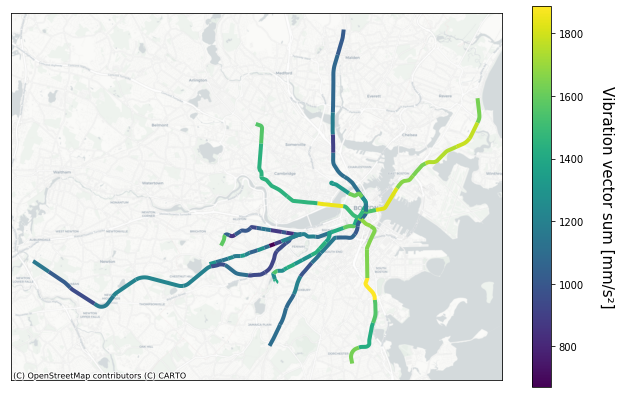

In [23]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))

temp = gdf_vibration[gdf_vibration["variable"] == "VECTOR_SUM.rms"]
temp = temp[temp["value"] < 2500] # TODO: investigate end of blue line
temp.plot(ax=axis, column="value", linewidth=4)

colormap = cm.get_cmap("viridis")
normalize = colors.Normalize(vmin=temp["value"].min(), vmax=temp["value"].max())
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap)
)
colorbar.set_label(
    "Vibration vector sum [mm/s²]",
    rotation=270,
    labelpad=30,
    fontsize=15
)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])

#axis.set_title("Geospatial distribution of vibration readings", fontsize=15)

Text(0.5, 1, 'Directional variations in vibration magnitude')

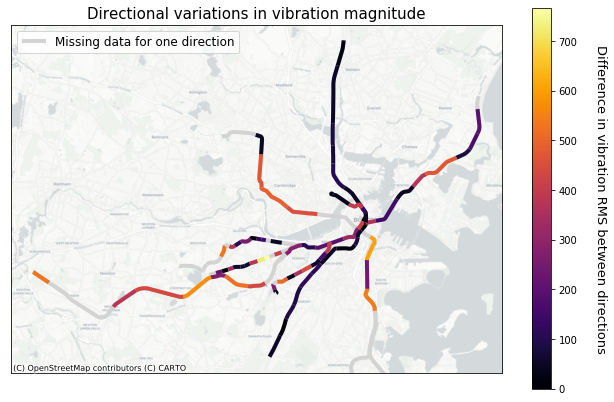

In [24]:
def difference_between_directions(df):
    dir0 = df[df["DIRECTION"] == 0]
    dir1 = df[df["DIRECTION"] == 1]
    if (len(dir0) == 0) or len(dir1) == 0:
        return None
    else:
        return abs(dir0.iloc[0]["value"] - dir1.iloc[0]["value"])

gdf_segments_diff = geopandas.GeoDataFrame(pandas.merge(
    pandas.read_csv("output/segments/by_direction/vibration.csv")\
        .query("variable=='VECTOR_SUM.rms'")\
        .groupby(["START_STATION", "END_STATION", "ROUTE"])\
        .apply(difference_between_directions)\
        .rename("difference")\
        .reset_index(),
    segments,
    on=["START_STATION", "END_STATION", "ROUTE"]
))

(figure, axis) = pyplot.subplots(figsize=(11, 7))

abs_max = gdf_segments_diff["difference"].abs().max()

colormap = cm.get_cmap("inferno")
normalize = colors.Normalize(vmin=0, vmax=abs_max)
colorbar = figure.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=colormap),
    ax=axis
)
colorbar.set_label(
    "Difference in vibration RMS between directions",
    rotation=270,
    labelpad=30,
    fontsize=13
)

gdf_segments_diff.plot(ax=axis, column="difference", linewidth=4, zorder=2, cmap=colormap)
xlim = axis.get_xlim()
ylim = axis.get_ylim()

segments.plot(ax=axis, color="lightgrey", linewidth=4, zorder=1, label="Missing data for one direction")
axis.set_xlim(xlim)
axis.set_ylim(ylim)

contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)

axis.set_xticks([])
axis.set_yticks([])
axis.legend(loc="upper left", fontsize=12)

pyplot.title("Directional variations in vibration magnitude", fontsize=15)

# correlation matrix

In [25]:
import functools
import numpy
import seaborn

/home/leaf/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
def unmelt(df, variable):
    return df.query("variable=='{}'".format(variable))\
        .set_index(["START_STATION", "END_STATION", "ROUTE"])\
        ["value"]\
        .rename(variable)\
        .reset_index()

df_all = functools.reduce(
    lambda left, right: pandas.merge(left, right, on=["START_STATION", "END_STATION", "ROUTE"]),
    [
        unmelt(pandas.read_csv("output/segments/directionless/noise.csv"), "CORRECTED_VALUE.median"),
        unmelt(pandas.read_csv("output/segments/directionless/particulates.csv"), "SMALLPARTICLES.mean"),
        unmelt(pandas.read_csv("output/segments/directionless/particulates.csv"), "LARGEPARTICLES.mean"),
        unmelt(pandas.read_csv("output/segments/directionless/vibration.csv"), "VECTOR_SUM.rms"),
    ]
).rename(
        {
            "CORRECTED_VALUE.median": "Noise",
            "SMALLPARTICLES.mean": "Small particles",
            "LARGEPARTICLES.mean": "Large particles",
            "VECTOR_SUM.rms": "Vibration",
        },
        axis=1
    )

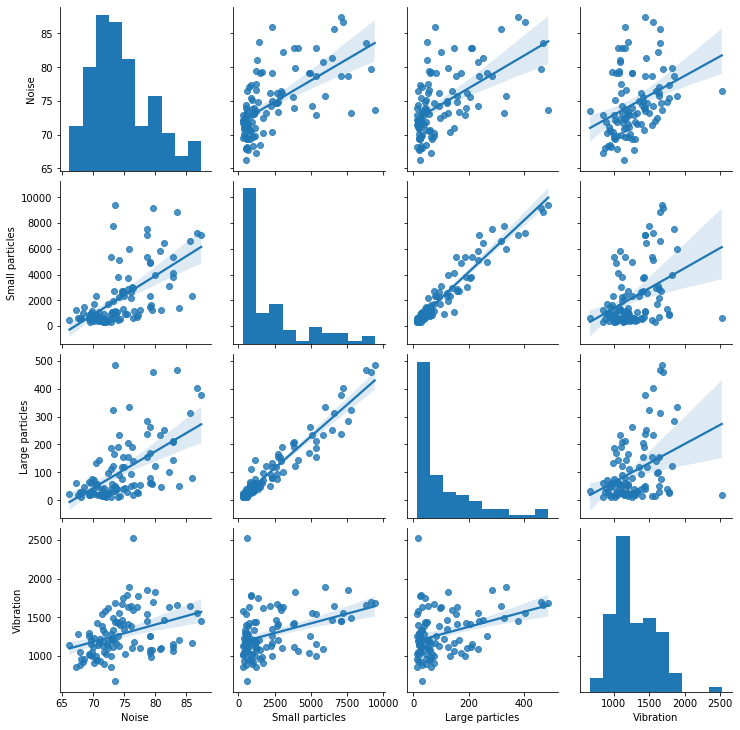

In [27]:
seaborn.pairplot(
    df_all,
    kind="reg",
    palette=seaborn.color_palette([NEU_COLOR])
)

Text(0.5, 1, 'Correlation matrix')

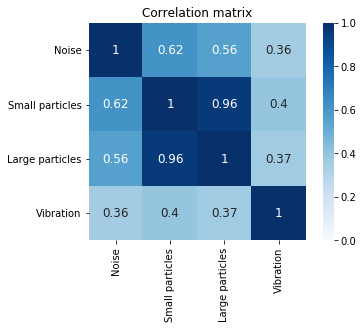

In [29]:
corr = df_all.corr()
axis = seaborn.heatmap(
    corr,
    mask=numpy.triu(numpy.zeros_like(corr, dtype=numpy.bool)),
    cmap="Blues",
    square=True,
    annot=True,
    annot_kws={"fontsize": 12},
    vmin=0
)
axis.set_title("Correlation matrix")

# coverage (geospatial)

Text(0.5, 1, '2018 pilot study coverage')

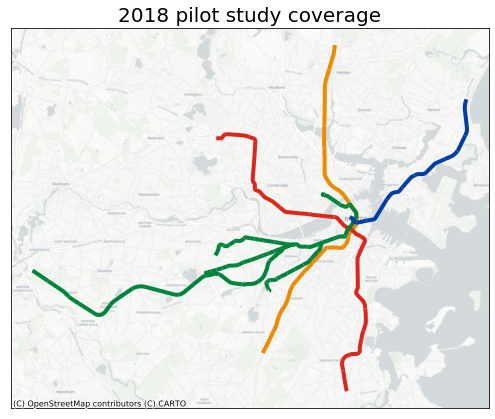

In [30]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))
for (line, color) in LINE_COLORS.items():
    gdf_noise[
        (gdf_noise["variable"] == "CORRECTED_VALUE.count")
        & (gdf_noise["LINE"] == line)
    ].plot(
        ax=axis,
        color=color,
        linewidth=4
    )
contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)
axis.set_xticks([])
axis.set_yticks([])
axis.set_title("2018 pilot study coverage", fontsize=20)

Text(0.5, 1, '2019 particulates follow up coverage')

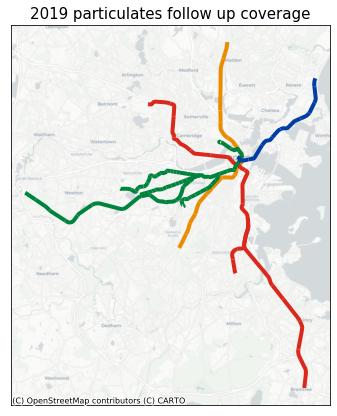

In [31]:
(figure, axis) = pyplot.subplots(figsize=(11, 7))
for (line, color) in LINE_COLORS.items():
    gdf_pm_segments[
        (gdf_pm_segments["variable"] == "SMALLPARTICLES.count")
        & (gdf_pm_segments["LINE"] == line)
    ].plot(
        ax=axis,
        color=color,
        linewidth=4
    )
contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)
axis.set_xticks([])
axis.set_yticks([])
axis.set_title("2019 particulates follow up coverage", fontsize=15)

# extra: NAAQS PMC -> PNC via Dacunto et al

In [32]:
df_naaqs = pandas.DataFrame(
    [
        ("primary", "1 year", 12),
        ("secondary", "1 year", 15),
        ("both", "24 hours", 35),
    ],
    columns=["standard", "averaging period", "PMC [ug/m3]"]
)

In [33]:
for (source, m, n) in [
    ("Cigarette", 1.09e-7, 2.111),
    ("Stick incense", 1.07e-5, 1.640),
    ("Candles + wood smoke", 8.76e-6, 1.782),
    ("Cigarette + food + incense + SHS", 4.59e-6, 1.761),
    ("All", 3.91e-6, 1.803),
]:
    df_naaqs[source + " [count/ft3]"] = (df_naaqs["PMC [ug/m3]"]/m)**(1/n)
df_naaqs

,standard,averaging period,PMC [ug/m3],Cigarette [count/ft3],Stick incense [count/ft3],Candles + wood smoke [count/ft3],Cigarette + food + incense + SHS [count/ft3],All [count/ft3]
0,primary,1 year,12,6448.411541,4885.408631,2777.807196,4407.188136,3961.821378
1,secondary,1 year,15,7167.371340,5597.477631,3148.363161,5002.566033,4483.779066
2,both,24 hours,35,10707.149663,9383.577717,5065.021982,8093.787951,7173.574287
